# First we solve the linear regression problem

In [1]:
import numpy as np
import numpy.random as rng
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import pymc3 as pm
import scipy.stats as stats
from sklearn.preprocessing import StandardScaler
import daft

In [2]:
import theano
theano.config.warn.round=False

setting up and fitting linear model

In [3]:
# observed data
np.random.seed(123)
n = 11
_a = 6
_b = 2
x = np.linspace(0,1,n)
y = _a*x + _b + np.random.randn(n)

In [4]:
niter = 10000
with pm.Model() as linreg:
    a = pm.Normal("a", mu=0, sd=100)
    b = pm.Normal("b", mu=0, sd=100)
    sigma = pm.HalfNormal("sigma", sd=1)
    
    y_est = a*x + b
    likelihood = pm.Normal("y", mu=y_est, sd=sigma, observed=y)
    
    trace = pm.sample(niter, random_seed=123)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, b, a]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:20<00:00, 2075.33draws/s]
The acceptance probability does not match the target. It is 0.8836245790814774, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8938653687653494, but should be close to 0.8. Try to increase the number of tuning steps.


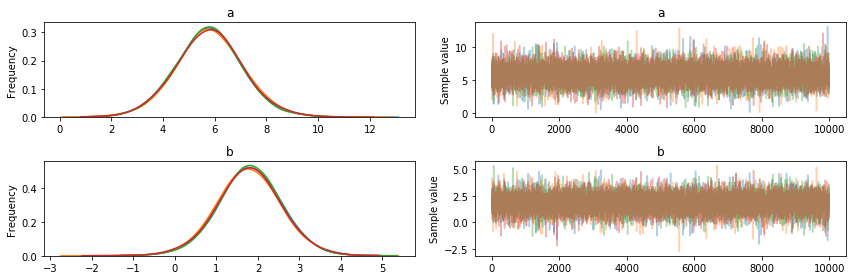

In [5]:
t = trace[niter//2:]
pm.traceplot(trace,varnames=["a","b"])
pass

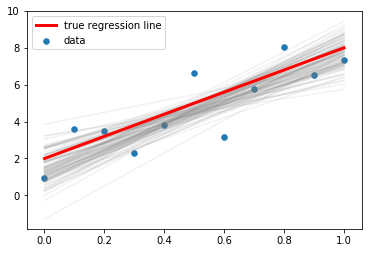

In [6]:
plt.scatter(x,y,s=30,label="data")
for a_, b_ in zip(t["a"][-100:], t["b"][-100:]):
    plt.plot(x,a_*x + b_, c="gray", alpha=0.1)
plt.plot(x, _a*x + _b, label="true regression line", lw=3., c="red")
plt.legend(loc="best")
pass

# the model problem

true model: $ y' = \theta y$, where $y(t_i) = f(\theta, i) = e^{\theta t_i}$

observations: $ z_i = y_i + \epsilon_i$, where $\epsilon_i \sim \mathcal{N}(0,\sigma)$

We can therefore see that the linear regression model has a lot of similarities, e.g., the likelihood for the model problem is 
$$P(z|\theta) = \mathcal{N}(z | y_i, \sigma)$$

we also assume a "simple" prior for $\theta$, naimly, $$P(\theta) = \mathcal{N}(0,100)$$

#### bonus
and for $\sigma$: 
$$P(\sigma) = |\mathcal{N}(0,1)|$$

### First assume only 1 observation of the time series


In [268]:
# generate observation
def gen_obs(N_t = 11, N_data=1):
    _theta = -2.5
    x = np.linspace(0,1,N_t)
    sigma = 0.1
    y = np.exp(_theta*x)
    z = y + np.random.normal(loc=0,
                             scale=sigma,
                             size=N_t*N_data).reshape(N_data,N_t)
    return(sigma, x, y, z)

np.random.seed(0)
N_data = 1
N_t = 11
sigma, x, y, z = gen_obs(N_t=N_t, N_data=N_data)

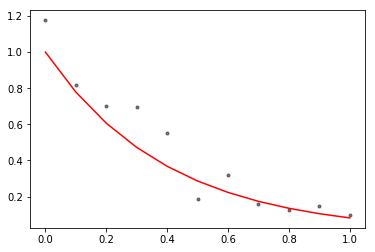

In [269]:
for i in range(N_data):
    plt.plot(x, z[i,:], '.k', alpha = 0.5)

plt.plot(x,y, "r")
pass

In [271]:
# infer parameters
def modelInfer(x, sigma, z, niter=10000, tune=500):
    with pm.Model() as modelProblem:
        theta = pm.Normal("theta", mu=0, sd=100)
        #sigma = pm.HalfNormal("sigma", sd=1)
    
        y_est = np.exp(theta*x)
        # if i'm totallty honest, I'm not sure if the following computes the likelihood we want.
        # but I think it does.
        likelihood = pm.Normal("y", mu=y_est, sd=sigma, observed=z)
    
        trace = pm.sample(niter, tune = tune, random_seed=123)
    return(modelProblem, trace)

In [272]:
model, trace = modelInfer(x,sigma,z, 10000, 1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta]
Sampling 4 chains: 100%|██████████| 44000/44000 [00:08<00:00, 5234.41draws/s]


In [273]:
def post_mean(trace):
    tt = trace[niter//2:]
    theta_mean = np.mean(tt["theta"])
    return(theta_mean)

In [274]:
post_mean(trace)

-2.1048584510729613

In [287]:
pm.summary(trace)["mean"][0]


-2.104002347248402

In [294]:
def plotit(model, trace, true=-2.5):
    tt = trace[niter//2:]
    pm.traceplot(trace, varnames=["theta"], figsize=[14,4])
    plt.show()
        
    summary = pm.summary(trace)
    print(summary)
    pm.plot_posterior(trace)
    plt.axvline(x=true, color="red")
    pass

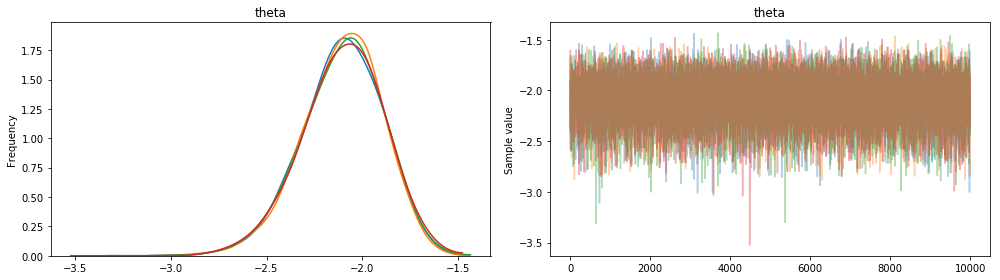

           mean        sd  mc_error   hpd_2.5  hpd_97.5        n_eff      Rhat
theta -2.104002  0.210457  0.001786 -2.519859 -1.702955  15885.65063  0.999984


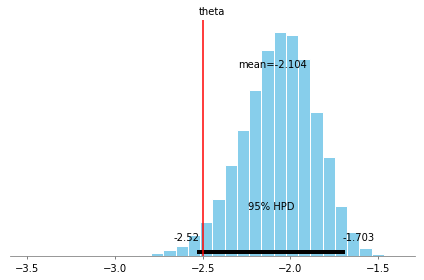

In [295]:
plotit(model,trace)

### now increase the number of observations, $N_\text{data}$
how does the mean behave?

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta]
Sampling 4 chains: 100%|██████████| 44000/44000 [00:08<00:00, 5366.69draws/s]


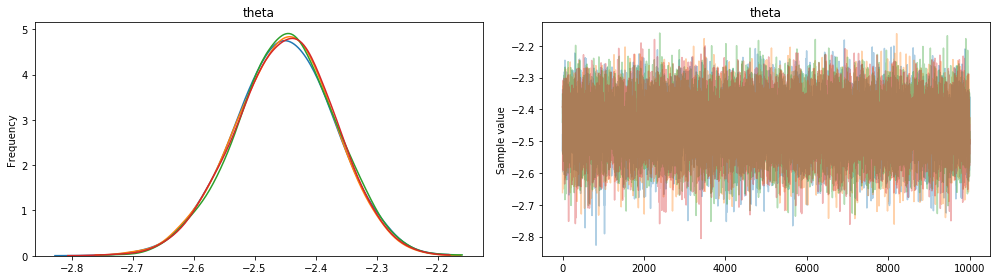

           mean        sd  mc_error   hpd_2.5  hpd_97.5         n_eff  \
theta -2.450619  0.080745  0.000609 -2.611938 -2.295822  17079.914308   

           Rhat  
theta  1.000188  


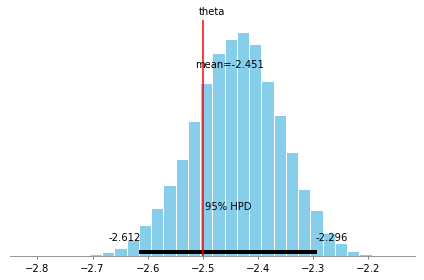

In [296]:
N_data = 10
N_t = 11
sigma, x, y, z = gen_obs(N_t, N_data)
model, trace = modelInfer(x, sigma, z, 10000, 1000)
plotit(model, trace)

#  Convergens
Evaluate the of the error wrt $\Delta t$ and $N_\text{data}$

Consider the error as $|E[\hat{y}] - y|$, where $y$ is the truth, and $\hat{y}$ is the computed posterior.

In [298]:
def comp_bias(trace, truth=-2.5):
    bias = np.abs(post_mean(trace) - truth)
    return(bias)

In [299]:
comp_bias(trace)

0.04899975996205086

In [539]:
N_data_vec = np.logspace(0,2,5, dtype = int)
N_t_vec = [11, 21, 41, 81, 161]
#N_t_vec = np.linspace(11,101,4, dtype = int)

bias_N = np.empty([len(N_data_vec), len(N_t_vec)])

np.random.seed(123)

print("for N: ", N_data_vec)
print("and, T: ", N_t_vec)

for i in range(len(N_t_vec)):
    N_t = N_t_vec[i]
    print("T: ", N_t)
    
    for j in range(len(N_data_vec)):
        N_data = N_data_vec[j]
        #print("N: ", N_data)
        
        # generate observation
        sigma, x, y, z = gen_obs(N_t=N_t, N_data=N_data)
    
        # infer parameters
        model, trace = modelInfer(x,sigma,z,10000,2000)
        
        # compute |bias|
        bias_N[j,i] = comp_bias(trace)

print("done")        

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


for N:  [  1   3  10  31 100]
and, T:  [11, 21, 41, 81, 161]
T:  11


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta]
Sampling 4 chains: 100%|██████████| 48000/48000 [00:08<00:00, 5346.75draws/s]
The acceptance probability does not match the target. It is 0.6854968665853273, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta]
Sampling 4 chains: 100%|██████████| 48000/48000 [00:13<00:00, 3524.30draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta]
Sampling 4 chains: 100%|██████████| 48000/48000 [00:14<00:00, 3326.48draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta]
Sampling 4 chains: 100%|██████████| 48000/48000 [00:14<00:00, 3254.53draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Mult

T:  21


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta]
Sampling 4 chains: 100%|██████████| 48000/48000 [00:13<00:00, 3511.95draws/s]
The acceptance probability does not match the target. It is 0.6435128928675945, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta]
Sampling 4 chains: 100%|██████████| 48000/48000 [00:14<00:00, 3386.16draws/s]
The acceptance probability does not match the target. It is 0.8973645799596217, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8887580308755917, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta]
Sampling 4 chains: 100%|██████████| 48000/48000 [00:14<00:00, 328

T:  41


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta]
Sampling 4 chains: 100%|██████████| 48000/48000 [00:14<00:00, 3254.18draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta]
Sampling 4 chains: 100%|██████████| 48000/48000 [00:14<00:00, 3306.71draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta]
Sampling 4 chains: 100%|██████████| 48000/48000 [00:14<00:00, 3315.34draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta]
Sampling 4 chains: 100%|██████████| 48000/48000 [00:14<00:00, 3306.77draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta]
Sampling 4 chains: 100%|██████████| 48000/48000 [00:15<00:00, 3114.62draws/s]
Auto-assigning NUTS s

T:  81


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta]
Sampling 4 chains: 100%|██████████| 48000/48000 [00:14<00:00, 3382.10draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta]
Sampling 4 chains: 100%|██████████| 48000/48000 [00:14<00:00, 3362.78draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta]
Sampling 4 chains: 100%|██████████| 48000/48000 [00:14<00:00, 3332.04draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta]
Sampling 4 chains: 100%|██████████| 48000/48000 [00:14<00:00, 3213.76draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta]
Sampling 4 chains: 100%|██████████| 48000/48000 [00:16<00:00, 2940.65draws/s]
Auto-assigning NUTS s

T:  161


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta]
Sampling 4 chains: 100%|██████████| 48000/48000 [00:14<00:00, 3402.68draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta]
Sampling 4 chains: 100%|██████████| 48000/48000 [00:14<00:00, 3370.50draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta]
Sampling 4 chains: 100%|██████████| 48000/48000 [00:14<00:00, 1812.40draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta]
Sampling 4 chains: 100%|██████████| 48000/48000 [00:15<00:00, 3030.87draws/s]
The acceptance probability does not match the target. It is 0.895445990456806, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multi

done


In [301]:
bias_N

array([[2.99520021e-01, 1.08782612e-01, 3.06992188e-03, 5.20785149e-02],
       [1.86338085e-01, 5.11244176e-02, 2.14515339e-02, 2.26674554e-02],
       [4.89997600e-02, 2.45675713e-02, 6.00644999e-03, 3.20347174e-03],
       [3.66963331e-02, 7.31618447e-03, 6.04257536e-03, 7.81546836e-03],
       [2.47008240e-04, 7.45384710e-03, 4.75979340e-03, 1.95208471e-03]])

## Plot the error over $\Delta_t$ and $N_\text{data}$

In [544]:
labelize = np.vectorize(lambda x: "$\Delta t: " + str(x))
N_t_labels = labelize(1/(np.array(N_t_vec)-1))

labels = N_t_labels.tolist()
labels.append("$N^{-0.5}$")

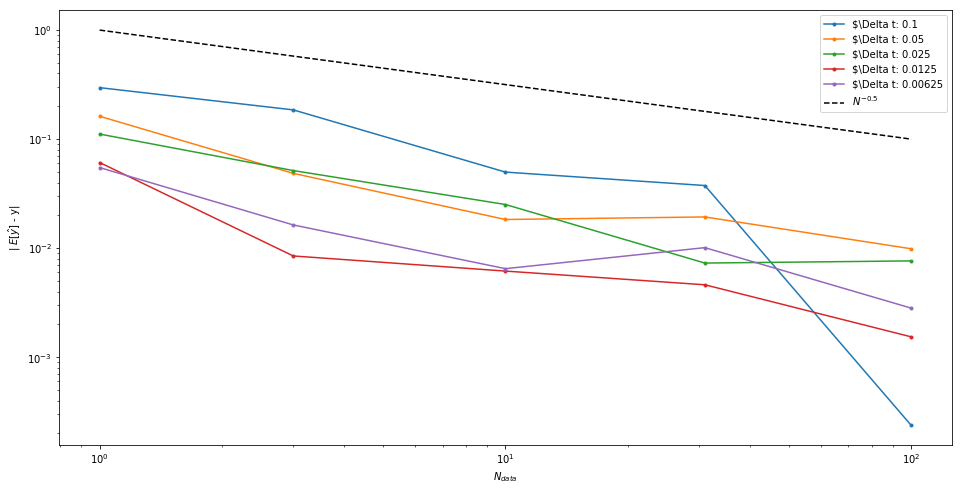

In [545]:
plt.figure(figsize=[16,8])
plt.loglog(N_data_vec, np.abs(bias_N), '.-')
plt.loglog(N_data_vec, N_data_vec**-0.5, '--k')
plt.legend(labels)
plt.xlabel("$N_{data}$")
plt.ylabel("| $E[\hat{y}]$ - y|")
pass

### A conclussion is
that you need more data. Meaning that either you decrease $\Delta t$ or you increase $N_\text{data}$.

# Cost vs error
The cost of computing one trajectory is $\frac{1}{\Delta t}$, and the cost of computing one likelihood is $N_\text{data}\frac{1}{\Delta t}$

In [546]:
N_data_mat = np.repeat(N_data_vec, len(N_t_vec)).reshape(len(N_data_vec),len(N_t_vec))

# each columns is N_t[i] and each row is N_data[i]
cost = (N_data_mat * N_t_vec)

cost_all = cost.reshape(len(N_data_vec)*len(N_t_vec),1)

bias_all = bias_N.reshape(len(N_data_vec)*len(N_t_vec),1)

In [547]:
# hypothesis
error_vec = np.logspace(-0,-3,10)
cost_vec = 1/(error_vec**1)



# linear fit
p_fit = np.polyfit(np.log(bias_all[:,0]), np.log(cost_all[:,0]), 1)
fitted_cost = np.polyval(p_fit, np.log(error_vec))


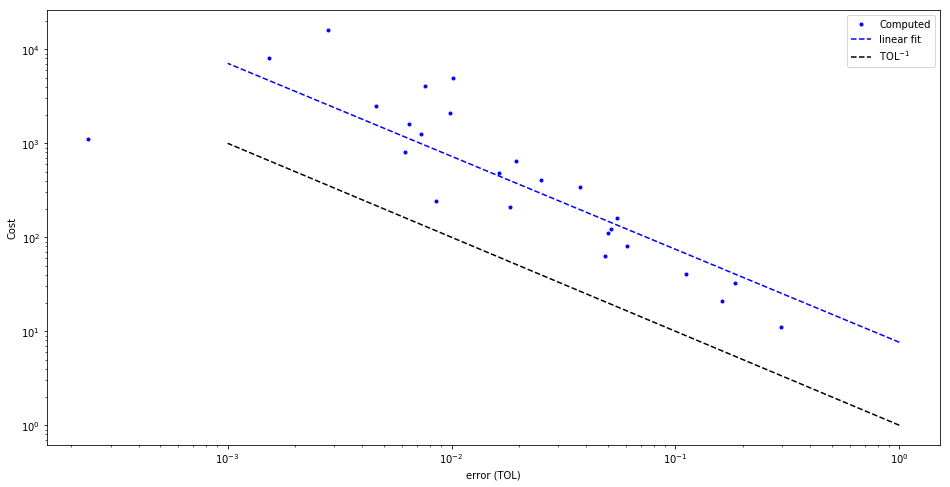

In [548]:
plt.figure(figsize=[16,8])
plt.loglog(bias_all, cost_all,  '.b')
plt.loglog(error_vec, np.exp(fitted_cost), '--b')
plt.loglog(error_vec, cost_vec, '--k')
plt.ylabel("Cost")
plt.xlabel("error (TOL)")
plt.legend(["Computed", "linear fit", "TOL$^{-1}$"])
pass